![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


# Preprocesamiento


In [5]:
cc_apps_nans_replaced = cc_apps.replace("?", np.NaN)
cc_apps_imputed = cc_apps_nans_replaced.copy()
for col in cc_apps_imputed.columns:
    if cc_apps_imputed[col].dtypes == "object":
        cc_apps_imputed[col] = cc_apps_imputed[col].fillna(
            cc_apps_imputed[col].value_counts().index[0]
        )
    else:
        cc_apps_imputed[col] = cc_apps_imputed[col].fillna(cc_apps_imputed[col].mean())
cc_apps_encoded = pd.get_dummies(cc_apps_imputed, drop_first=True)


# Prepare the data

In [6]:
X = cc_apps_encoded.iloc[:, :-1].values
y = cc_apps_encoded.iloc[:, [-1]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

# Modelling

In [7]:
logreg = LogisticRegression()

logreg.fit(rescaledX_train, y_train)

y_train_pred = logreg.predict(rescaledX_train)

print(confusion_matrix(y_train, y_train_pred))


[[203   1]
 [  1 257]]


# Find the best scoring

In [8]:
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

param_grid = dict(tol=tol, max_iter=max_iter)

grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

grid_model_result = grid_model.fit(rescaledX_train, y_train)

best_train_score, best_train_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_train_score, best_train_params))

best_model = grid_model_result.best_estimator_
best_score =  best_model.score(rescaledX_test, y_test)

print("Accuracy of logistic regression classifier: ", best_score)

Best: 0.818163 using {'max_iter': 100, 'tol': 0.01}
Accuracy of logistic regression classifier:  0.793859649122807


# Visualization


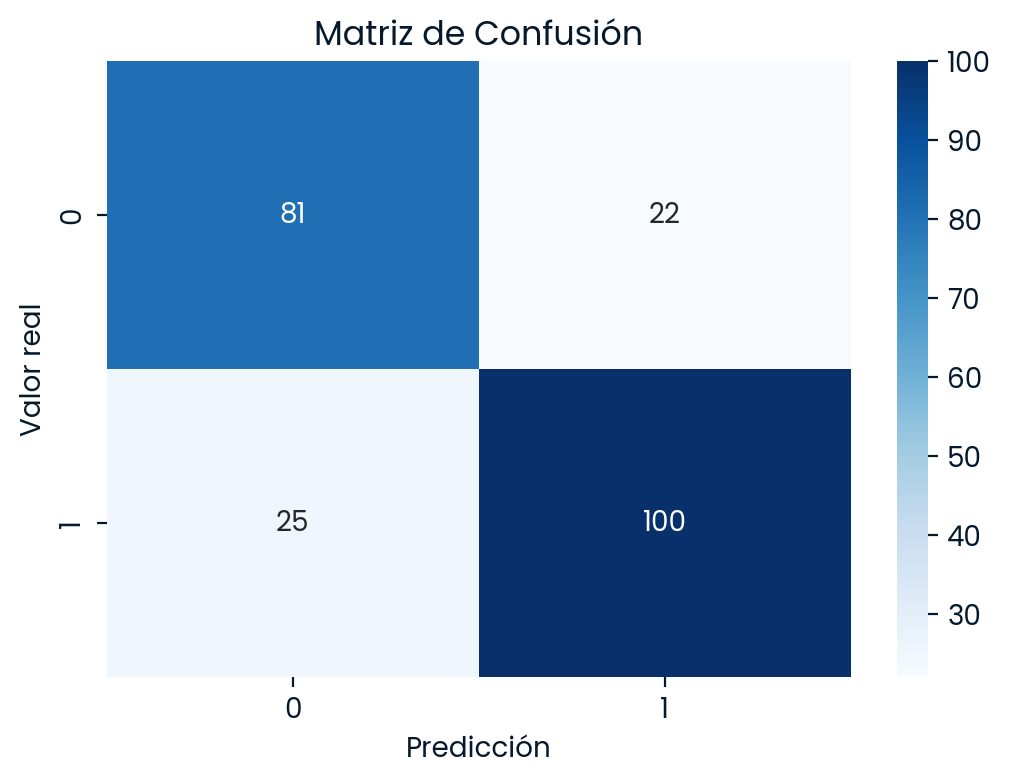

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, best_model.predict(rescaledX_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()


Best: 0.824708 using {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy of optimized logistic regression classifier:  0.8026315789473685


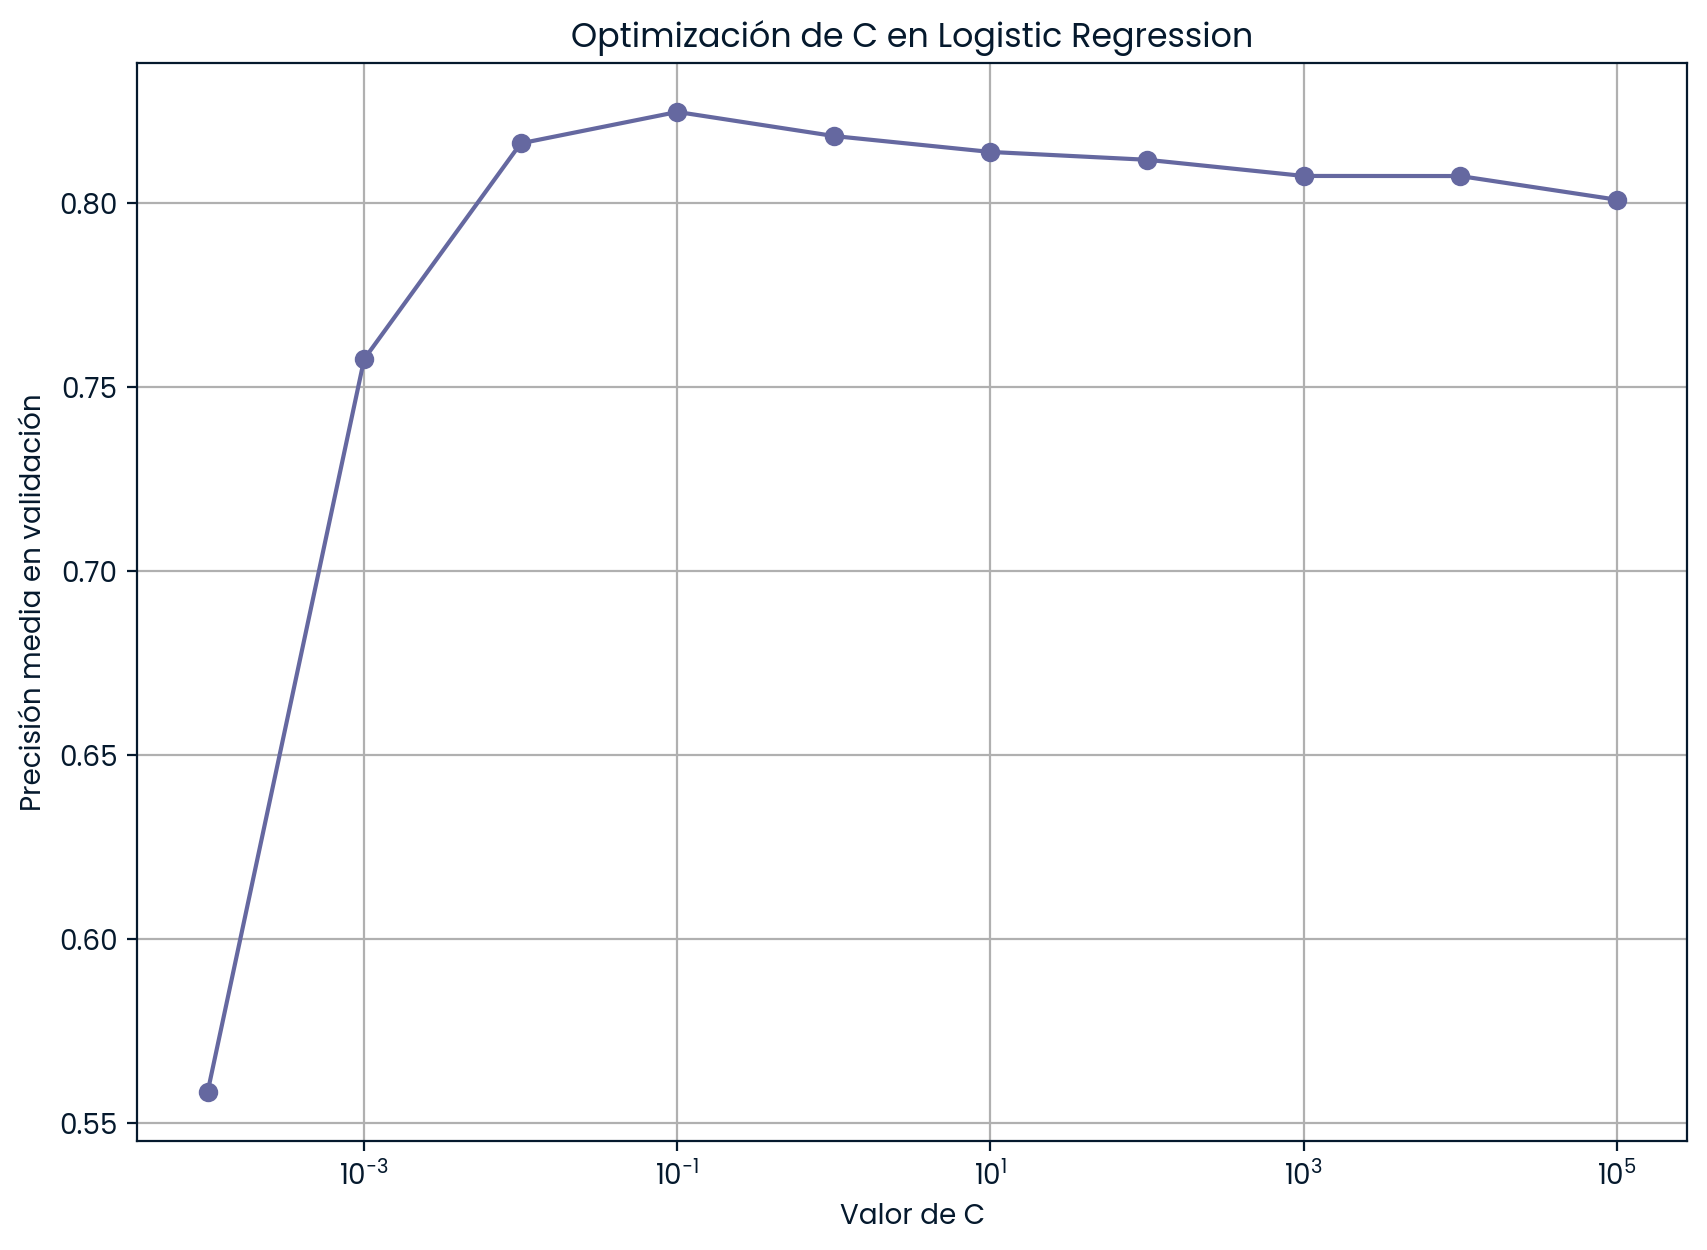

In [19]:
param_grid_new = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_model_new = GridSearchCV(estimator=logreg, param_grid=param_grid_new, cv=5, n_jobs=-1)

grid_model_result_new = grid_model_new.fit(rescaledX_train, y_train.ravel())

best_train_score_new, best_train_params_new = grid_model_result_new.best_score_, grid_model_result_new.best_params_
print("Best: %f using %s" % (best_train_score_new, best_train_params_new))

best_model_new = grid_model_result_new.best_estimator_
best_score_new = best_model_new.score(rescaledX_test, y_test)

print("Accuracy of optimized logistic regression classifier: ", best_score_new)
results_new = pd.DataFrame(grid_model_result_new.cv_results_)

plt.figure(figsize=(10,7))
plt.plot(results_new['param_C'], results_new['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Valor de C')
plt.ylabel('Precisión media en validación')
plt.title('Optimización de C en Logistic Regression')
plt.grid(True)
plt.show()
